# 🫁 Respiratory Disease Classification using GRU

This notebook implements a GRU-based model for classifying respiratory diseases from cough and vowel audio.

**Classes:**
- 0: Healthy
- 1: COPD
- 2: Asthma

**Model Architecture:**
- Bidirectional GRU with Attention mechanism
- MFCC + Delta + Delta-Delta features
- Data Augmentation (noise, shift, speed, gain)
- Mixup Augmentation

## 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Audio processing
import librosa
import librosa.display

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    fbeta_score, classification_report, confusion_matrix
)

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


## 2. Configuration

In [ ]:
class Config:
    """Configuration for the GRU respiratory disease classifier"""
    
    # Paths
    BASE_PATH = Path('/mnt/ml_storage/Final_Project/SOURCE2')
    TRAIN_CSV = BASE_PATH / 'train.csv'
    TEST_CSV = BASE_PATH / 'test.csv'
    COUGH_PATH = BASE_PATH / 'dataclean_cough_1'
    VOWEL_PATH = BASE_PATH / 'dataclean_vowel_1'
    MODEL_DIR = BASE_PATH / 'models'
    
    # Audio parameters
    SAMPLE_RATE = 16000
    DURATION = 1.0  # seconds - longer duration for more context
    N_MFCC = 20  # More MFCC coefficients for richer features
    N_FFT = 2048  # Better frequency resolution
    HOP_LENGTH = 512
    N_MELS = 64
    
    # Feature parameters
    INPUT_SIZE = N_MFCC * 3  # MFCC + delta + delta-delta = 60 features
    COMBINE_MODE = "concat"  # concat, average, cough_only, vowel_only
    
    # GRU Model parameters
    HIDDEN_SIZE = 128  # Smaller to prevent overfitting
    NUM_LAYERS = 2
    BIDIRECTIONAL = True
    DROPOUT = 0.4
    OUTPUT_SIZE = 3  # 3 classes
    
    # Training parameters
    BATCH_SIZE = 16
    NUM_EPOCHS = 150
    LEARNING_RATE = 0.0005
    WEIGHT_DECAY = 1e-3
    PATIENCE = 25
    VAL_SPLIT = 0.2
    GRADIENT_CLIP = 1.0
    
    # Augmentation
    USE_AUGMENTATION = True
    MIXUP_ALPHA = 0.2

config = Config()

# Create model directory
config.MODEL_DIR.mkdir(exist_ok=True)

print("GRU Configuration:")
print(f"  Audio: {config.SAMPLE_RATE}Hz, {config.DURATION}s, {config.N_MFCC} MFCCs")
print(f"  Features: {config.INPUT_SIZE} per audio type")
print(f"  GRU: hidden={config.HIDDEN_SIZE}, layers={config.NUM_LAYERS}, bidirectional={config.BIDIRECTIONAL}")
print(f"  Training: batch={config.BATCH_SIZE}, lr={config.LEARNING_RATE}, epochs={config.NUM_EPOCHS}")
print(f"  Augmentation: {config.USE_AUGMENTATION}, mixup_alpha={config.MIXUP_ALPHA}")

GRU Configuration:
  Audio: 16000Hz, 2.0s, 20 MFCCs
  Features: 60 per audio type
  GRU: hidden=128, layers=2, bidirectional=True
  Training: batch=16, lr=0.0005, epochs=150
  Augmentation: True, mixup_alpha=0.2


## 3. Load Data

In [3]:
# Load training and test data
train_df = pd.read_csv(config.TRAIN_CSV)
test_df = pd.read_csv(config.TEST_CSV)

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

# Check class distribution
print(f"\nClass distribution:")
print(train_df['disease'].value_counts().sort_index())

# Compute class weights
def compute_class_weights(labels, method='sqrt'):
    """Compute class weights for imbalanced data"""
    unique_classes = np.unique(labels)
    class_counts = np.bincount(labels.astype(int))
    
    if method == 'sqrt':
        class_weights = np.sqrt(1.0 / class_counts)
    elif method == 'inverse':
        class_weights = 1.0 / class_counts
    else:
        class_weights = np.ones(len(unique_classes))
    
    class_weights = class_weights / class_weights.sum() * len(unique_classes)
    
    print(f"\nClass weights ({method}):")
    for i, (count, weight) in enumerate(zip(class_counts, class_weights)):
        class_name = ['Healthy', 'COPD', 'Asthma'][i]
        print(f"  Class {i} ({class_name}): count={count}, weight={weight:.4f}")
    
    return torch.FloatTensor(class_weights)

Training samples: 546
Test samples: 338

Class distribution:
disease
0    140
1    238
2    168
Name: count, dtype: int64


## 4. Dataset Class with Augmentation

In [4]:
class RespiratoryDataset(Dataset):
    """Dataset that combines cough and vowel audio features with augmentation"""
    
    def __init__(self, candidate_ids, labels, config, is_test=False, augment=False):
        self.candidate_ids = candidate_ids
        self.labels = labels
        self.config = config
        self.is_test = is_test
        self.augment = augment and not is_test
        self.cough_path = config.COUGH_PATH
        self.vowel_path = config.VOWEL_PATH
    
    def __len__(self):
        return len(self.candidate_ids)
    
    def _augment_audio(self, audio):
        """Apply random audio augmentations"""
        if not self.augment or np.random.random() > 0.5:
            return audio
        
        aug_type = np.random.choice(['noise', 'shift', 'speed', 'gain'])
        
        if aug_type == 'noise':
            noise_factor = np.random.uniform(0.001, 0.005)
            noise = np.random.randn(len(audio)) * noise_factor
            audio = audio + noise
        elif aug_type == 'shift':
            shift_max = int(len(audio) * 0.1)
            shift = np.random.randint(-shift_max, shift_max)
            audio = np.roll(audio, shift)
        elif aug_type == 'speed':
            speed_factor = np.random.uniform(0.95, 1.05)
            audio = librosa.effects.time_stretch(audio, rate=speed_factor)
            target_len = int(self.config.SAMPLE_RATE * self.config.DURATION)
            if len(audio) > target_len:
                audio = audio[:target_len]
            else:
                audio = np.pad(audio, (0, target_len - len(audio)), mode='constant')
        elif aug_type == 'gain':
            gain_factor = np.random.uniform(0.8, 1.2)
            audio = audio * gain_factor
        
        return audio
    
    def _load_and_extract_features(self, audio_path):
        """Load audio and extract MFCC features"""
        try:
            audio, sr = librosa.load(audio_path, sr=self.config.SAMPLE_RATE)
            
            target_samples = int(self.config.SAMPLE_RATE * self.config.DURATION)
            if len(audio) > target_samples:
                audio = audio[:target_samples]
            else:
                audio = np.pad(audio, (0, target_samples - len(audio)), mode='constant')
            
            if self.augment:
                audio = self._augment_audio(audio)
            
            mfcc = librosa.feature.mfcc(
                y=audio,
                sr=self.config.SAMPLE_RATE,
                n_mfcc=self.config.N_MFCC,
                n_fft=self.config.N_FFT,
                hop_length=self.config.HOP_LENGTH,
                n_mels=self.config.N_MELS
            )
            
            delta = librosa.feature.delta(mfcc)
            delta_delta = librosa.feature.delta(mfcc, order=2)
            
            features = np.vstack([mfcc, delta, delta_delta])
            features = features.T
            features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
            features = np.clip(features, -1e6, 1e6)
            
            return features
            
        except Exception as e:
            print(f"Error loading {audio_path}: {str(e)}")
            expected_frames = int((self.config.SAMPLE_RATE * self.config.DURATION) / self.config.HOP_LENGTH) + 1
            return np.zeros((expected_frames, self.config.INPUT_SIZE))
    
    def __getitem__(self, idx):
        candidate_id = self.candidate_ids[idx]
        
        cough_audio_path = self.cough_path / candidate_id / 'cough.wav'
        vowel_audio_path = self.vowel_path / candidate_id / 'vowel.wav'
        
        cough_features = self._load_and_extract_features(cough_audio_path)
        vowel_features = self._load_and_extract_features(vowel_audio_path)
        
        if self.config.COMBINE_MODE == "concat":
            combined = np.concatenate([cough_features, vowel_features], axis=1)
        elif self.config.COMBINE_MODE == "average":
            combined = (cough_features + vowel_features) / 2.0
        elif self.config.COMBINE_MODE == "cough_only":
            combined = cough_features
        elif self.config.COMBINE_MODE == "vowel_only":
            combined = vowel_features
        else:
            raise ValueError(f"Unknown combine_mode: {self.config.COMBINE_MODE}")
        
        audio_tensor = torch.FloatTensor(combined)
        
        if self.is_test:
            return audio_tensor, candidate_id
        else:
            label = torch.LongTensor([self.labels[idx]])[0]
            return audio_tensor, label, candidate_id


def collate_fn(batch):
    """Collate function to handle variable-length sequences"""
    if len(batch[0]) == 2:
        audio_features = [item[0] for item in batch]
        candidate_ids = [item[1] for item in batch]
        audio_padded = nn.utils.rnn.pad_sequence(audio_features, batch_first=True)
        lengths = torch.LongTensor([len(x) for x in audio_features])
        return audio_padded, lengths, candidate_ids
    else:
        audio_features = [item[0] for item in batch]
        labels = torch.stack([item[1] for item in batch])
        candidate_ids = [item[2] for item in batch]
        audio_padded = nn.utils.rnn.pad_sequence(audio_features, batch_first=True)
        lengths = torch.LongTensor([len(x) for x in audio_features])
        return audio_padded, lengths, labels, candidate_ids


print("Dataset class defined!")

Dataset class defined!


## 5. GRU Model with Attention

In [5]:
class RespiratoryGRU(nn.Module):
    """GRU-based model for respiratory disease classification with attention mechanism"""
    
    def __init__(self, config):
        super(RespiratoryGRU, self).__init__()
        
        self.config = config
        self.hidden_size = config.HIDDEN_SIZE
        self.num_layers = config.NUM_LAYERS
        self.bidirectional = config.BIDIRECTIONAL
        
        # Calculate actual input size based on combine mode
        if config.COMBINE_MODE == "concat":
            input_size = config.INPUT_SIZE * 2  # 120 features (60 cough + 60 vowel)
        else:
            input_size = config.INPUT_SIZE  # 60 features
        
        # Input batch normalization
        self.batch_norm_input = nn.BatchNorm1d(input_size)
        
        # GRU layers (instead of LSTM)
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=config.HIDDEN_SIZE,
            num_layers=config.NUM_LAYERS,
            batch_first=True,
            dropout=config.DROPOUT if config.NUM_LAYERS > 1 else 0,
            bidirectional=config.BIDIRECTIONAL
        )
        
        # Calculate GRU output size
        gru_output_size = config.HIDDEN_SIZE * 2 if config.BIDIRECTIONAL else config.HIDDEN_SIZE
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(gru_output_size, gru_output_size // 2),
            nn.Tanh(),
            nn.Linear(gru_output_size // 2, 1)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(gru_output_size, config.HIDDEN_SIZE),
            nn.ReLU(),
            nn.BatchNorm1d(config.HIDDEN_SIZE),
            nn.Dropout(config.DROPOUT),
            nn.Linear(config.HIDDEN_SIZE, config.HIDDEN_SIZE // 2),
            nn.ReLU(),
            nn.BatchNorm1d(config.HIDDEN_SIZE // 2),
            nn.Dropout(config.DROPOUT),
            nn.Linear(config.HIDDEN_SIZE // 2, config.OUTPUT_SIZE)
        )
    
    def forward(self, audio_features, lengths):
        batch_size = audio_features.size(0)
        
        # Apply batch normalization
        audio_features_transposed = audio_features.transpose(1, 2)
        audio_features_normed = self.batch_norm_input(audio_features_transposed)
        audio_features = audio_features_normed.transpose(1, 2)
        
        # Pack padded sequences
        packed_input = nn.utils.rnn.pack_padded_sequence(
            audio_features, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # GRU forward pass
        packed_output, hidden = self.gru(packed_input)
        
        # Unpack sequences
        gru_output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        # Apply attention mechanism
        attention_weights = self.attention(gru_output)
        attention_weights = torch.softmax(attention_weights, dim=1)
        
        # Weighted sum using attention
        attended_output = torch.sum(gru_output * attention_weights, dim=1)
        
        # Classification
        logits = self.classifier(attended_output)
        
        return logits
    
    def _init_weights(self):
        """Initialize weights to avoid initial bias"""
        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'gru' in name:
                    nn.init.orthogonal_(param)
                elif 'bn' in name or 'batch_norm' in name:
                    nn.init.ones_(param)
                elif len(param.shape) >= 2:
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        
        # Initialize final layer with small weights
        final_layer = self.classifier[-1]
        nn.init.xavier_uniform_(final_layer.weight, gain=0.1)
        nn.init.zeros_(final_layer.bias)


print("GRU Model class defined!")

GRU Model class defined!


## 6. Training Functions

In [6]:
def mixup_data(x, y, alpha=0.2):
    """Apply Mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Compute Mixup loss"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def train_epoch(model, dataloader, criterion, optimizer, device, config, use_mixup=False):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(dataloader, desc="Training")
    for audio, lengths, labels, _ in progress_bar:
        audio = audio.to(device)
        labels = labels.to(device)
        
        if torch.isnan(audio).any():
            continue
        
        # Apply Mixup
        if use_mixup and config.MIXUP_ALPHA > 0:
            audio, labels_a, labels_b, lam = mixup_data(audio, labels, config.MIXUP_ALPHA)
        
        optimizer.zero_grad()
        outputs = model(audio, lengths)
        
        if torch.isnan(outputs).any():
            continue
        
        # Compute loss
        if use_mixup and config.MIXUP_ALPHA > 0:
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            all_labels.extend(labels_a.cpu().numpy())
        else:
            loss = criterion(outputs, labels)
            all_labels.extend(labels.cpu().numpy())
        
        if torch.isnan(loss):
            continue
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.GRADIENT_CLIP)
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(dataloader) if len(dataloader) > 0 else float('inf')
    accuracy = accuracy_score(all_labels, all_preds) if len(all_labels) > 0 else 0.0
    
    unique_preds, pred_counts = np.unique(all_preds, return_counts=True)
    pred_dist = {int(cls): int(cnt) for cls, cnt in zip(unique_preds, pred_counts)}
    
    return avg_loss, accuracy, pred_dist


def validate_epoch(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for audio, lengths, labels, _ in tqdm(dataloader, desc="Validation"):
            audio = audio.to(device)
            labels = labels.to(device)
            
            outputs = model(audio, lengths)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy, all_preds, all_labels, all_probs


def evaluate_model(y_true, y_pred, title="Evaluation"):
    """Comprehensive model evaluation"""
    print(f"\n{'='*60}")
    print(f"{title}")
    print(f"{'='*60}")
    
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = fbeta_score(y_true, y_pred, beta=1, average='weighted', zero_division=0)
    f1_macro = fbeta_score(y_true, y_pred, beta=1, average='macro', zero_division=0)
    
    print(f"\nMetrics:")
    print(f"  Accuracy:       {acc:.4f}")
    print(f"  Precision:      {precision:.4f}")
    print(f"  Recall:         {recall:.4f}")
    print(f"  F1 (weighted):  {f1:.4f}")
    print(f"  F1 (macro):     {f1_macro:.4f}")
    
    print(f"\nClassification Report:")
    class_names = ['Healthy', 'COPD', 'Asthma']
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_weighted': f1,
        'f1_macro': f1_macro,
        'confusion_matrix': cm
    }


print("Training functions defined!")

Training functions defined!


## 7. Prepare Data

In [7]:
# Filter out samples with missing audio files
print("Filtering out samples with missing audio files...")

def check_audio_exists(candidate_id, config):
    """Check if both cough and vowel audio files exist"""
    cough_path = config.COUGH_PATH / candidate_id / 'cough.wav'
    vowel_path = config.VOWEL_PATH / candidate_id / 'vowel.wav'
    return cough_path.exists() and vowel_path.exists()

# Filter training data
original_train_count = len(train_df)
train_df['has_audio'] = train_df['candidateID'].apply(lambda x: check_audio_exists(x, config))
train_df_filtered = train_df[train_df['has_audio']].copy()
removed_train = original_train_count - len(train_df_filtered)

print(f"Training: {original_train_count} -> {len(train_df_filtered)} (removed {removed_train} with missing files)")

# Filter test data
original_test_count = len(test_df)
test_df['has_audio'] = test_df['candidateID'].apply(lambda x: check_audio_exists(x, config))
test_missing_ids = test_df[~test_df['has_audio']]['candidateID'].tolist()
print(f"Test: {original_test_count} total, {len(test_missing_ids)} with missing files")

# Use filtered training data
train_df = train_df_filtered

# Check class distribution after filtering
print(f"\nClass distribution after filtering:")
print(train_df['disease'].value_counts().sort_index())

# Split training data
train_ids = train_df['candidateID'].values
train_labels = train_df['disease'].values

train_ids, val_ids, train_labels, val_labels = train_test_split(
    train_ids, train_labels, 
    test_size=config.VAL_SPLIT, 
    random_state=42,
    stratify=train_labels
)

print(f"\nData split:")
print(f"  Training: {len(train_ids)}")
print(f"  Validation: {len(val_ids)}")
print(f"  Test: {len(test_df)}")

# Create datasets
print("\nCreating datasets...")
train_dataset = RespiratoryDataset(train_ids, train_labels, config, is_test=False, augment=config.USE_AUGMENTATION)
val_dataset = RespiratoryDataset(val_ids, val_labels, config, is_test=False, augment=False)
test_dataset = RespiratoryDataset(test_df['candidateID'].values, None, config, is_test=True, augment=False)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=config.BATCH_SIZE, shuffle=True,
    collate_fn=collate_fn, num_workers=0, pin_memory=torch.cuda.is_available()
)

val_loader = DataLoader(
    val_dataset, batch_size=config.BATCH_SIZE, shuffle=False,
    collate_fn=collate_fn, num_workers=0, pin_memory=torch.cuda.is_available()
)

test_loader = DataLoader(
    test_dataset, batch_size=config.BATCH_SIZE, shuffle=False,
    collate_fn=collate_fn, num_workers=0, pin_memory=torch.cuda.is_available()
)

print(f"\nDataloaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

Filtering out samples with missing audio files...
Training: 546 -> 533 (removed 13 with missing files)
Test: 338 total, 2 with missing files

Class distribution after filtering:
disease
0    137
1    238
2    158
Name: count, dtype: int64

Data split:
  Training: 426
  Validation: 107
  Test: 338

Creating datasets...

Dataloaders created:
  Train batches: 27
  Val batches: 7
  Test batches: 22


## 8. Initialize Model & Training

In [8]:
# Initialize GRU model
print("Initializing GRU model...")
model = RespiratoryGRU(config).to(device)
model._init_weights()
print("✓ Applied balanced weight initialization")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Compute class weights
class_weights = compute_class_weights(train_labels, method='sqrt')
class_weights = class_weights.to(device)

# Loss function
print("\nUsing CrossEntropyLoss with sqrt class weights")
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)

# Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

Initializing GRU model...
✓ Applied balanced weight initialization

Model Architecture:
RespiratoryGRU(
  (batch_norm_input): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru): GRU(120, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (attention): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=64, out_features=3, bias=True)
  )
)

Total parameters: 563,444
Trai

## 9. Training Loop

In [9]:
# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'learning_rate': []
}

best_val_loss = float('inf')
best_val_acc = 0
patience_counter = 0
best_f1 = 0

print(f"\nStarting GRU training for {config.NUM_EPOCHS} epochs...")
print(f"Using learning rate: {config.LEARNING_RATE}")

for epoch in range(config.NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{config.NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Training phase with mixup
    train_loss, train_acc, train_pred_dist = train_epoch(
        model, train_loader, criterion, optimizer, device, config, 
        use_mixup=config.USE_AUGMENTATION
    )
    
    # Validation phase
    val_loss, val_acc, val_preds, val_labels_epoch, val_probs = validate_epoch(
        model, val_loader, criterion, device
    )
    
    # Calculate F1 score
    val_f1 = fbeta_score(val_labels_epoch, val_preds, beta=1, average='macro', zero_division=0)
    
    # Prediction distribution
    unique_preds, pred_counts = np.unique(val_preds, return_counts=True)
    val_pred_dist = {int(cls): int(cnt) for cls, cnt in zip(unique_preds, pred_counts)}
    
    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rate'].append(current_lr)
    
    # Print results
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
    print(f"  Learning Rate: {current_lr:.6f}")
    print(f"  Train Preds: Class 0={train_pred_dist.get(0,0)}, Class 1={train_pred_dist.get(1,0)}, Class 2={train_pred_dist.get(2,0)}")
    print(f"  Val Preds: Class 0={val_pred_dist.get(0,0)}, Class 1={val_pred_dist.get(1,0)}, Class 2={val_pred_dist.get(2,0)}")
    
    # Check for class collapse
    if len(val_pred_dist) == 1:
        print(f"  ⚠️  WARNING: Model is only predicting class {list(val_pred_dist.keys())[0]}!")
    
    # Save best model based on F1
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_f1': val_f1,
            'config': config,
        }, config.MODEL_DIR / 'best_gru_model.pth')
        
        print(f"  ✓ Best GRU model saved! (Val F1: {val_f1:.4f}, Val Acc: {val_acc:.4f})")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{config.PATIENCE})")
    
    # Early stopping
    if patience_counter >= config.PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print(f"\n{'='*60}")
print(f"Training completed!")
print(f"Best Val F1: {best_f1:.4f}")
print(f"Best Val Acc: {best_val_acc:.4f}")
print(f"{'='*60}")


Starting GRU training for 150 epochs...
Using learning rate: 0.0005

Epoch 1/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.55it/s]




Results:
  Train Loss: 1.1139, Train Acc: 0.3263
  Val Loss: 1.0923, Val Acc: 0.3738, Val F1: 0.3576
  Learning Rate: 0.000488
  Train Preds: Class 0=117, Class 1=160, Class 2=149
  Val Preds: Class 0=74, Class 1=9, Class 2=24
  ✓ Best GRU model saved! (Val F1: 0.3576, Val Acc: 0.3738)

Epoch 2/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]




Results:
  Train Loss: 1.0752, Train Acc: 0.4202
  Val Loss: 1.0526, Val Acc: 0.5794, Val F1: 0.5669
  Learning Rate: 0.000452
  Train Preds: Class 0=127, Class 1=170, Class 2=129
  Val Preds: Class 0=33, Class 1=43, Class 2=31
  ✓ Best GRU model saved! (Val F1: 0.5669, Val Acc: 0.5794)

Epoch 3/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]



Results:
  Train Loss: 1.0444, Train Acc: 0.4577
  Val Loss: 1.0327, Val Acc: 0.5607, Val F1: 0.5558
  Learning Rate: 0.000397
  Train Preds: Class 0=135, Class 1=140, Class 2=151
  Val Preds: Class 0=36, Class 1=38, Class 2=33
  No improvement (1/25)

Epoch 4/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]



Results:
  Train Loss: 1.0165, Train Acc: 0.5023
  Val Loss: 1.0233, Val Acc: 0.5140, Val F1: 0.5105
  Learning Rate: 0.000328
  Train Preds: Class 0=137, Class 1=143, Class 2=146
  Val Preds: Class 0=37, Class 1=34, Class 2=36
  No improvement (2/25)

Epoch 5/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.35it/s]



Results:
  Train Loss: 0.9870, Train Acc: 0.4108
  Val Loss: 1.0130, Val Acc: 0.5327, Val F1: 0.5184
  Learning Rate: 0.000251
  Train Preds: Class 0=142, Class 1=148, Class 2=136
  Val Preds: Class 0=39, Class 1=42, Class 2=26
  No improvement (3/25)

Epoch 6/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.62it/s]



Results:
  Train Loss: 0.9477, Train Acc: 0.4789
  Val Loss: 1.0154, Val Acc: 0.4953, Val F1: 0.4887
  Learning Rate: 0.000173
  Train Preds: Class 0=134, Class 1=150, Class 2=142
  Val Preds: Class 0=38, Class 1=40, Class 2=29
  No improvement (4/25)

Epoch 7/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.59it/s]



Results:
  Train Loss: 0.9419, Train Acc: 0.4648
  Val Loss: 1.0148, Val Acc: 0.4860, Val F1: 0.4803
  Learning Rate: 0.000104
  Train Preds: Class 0=133, Class 1=148, Class 2=145
  Val Preds: Class 0=39, Class 1=38, Class 2=30
  No improvement (5/25)

Epoch 8/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.53it/s]



Results:
  Train Loss: 0.9301, Train Acc: 0.4718
  Val Loss: 1.0123, Val Acc: 0.4953, Val F1: 0.4859
  Learning Rate: 0.000049
  Train Preds: Class 0=137, Class 1=150, Class 2=139
  Val Preds: Class 0=38, Class 1=42, Class 2=27
  No improvement (6/25)

Epoch 9/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.36it/s]




Results:
  Train Loss: 0.9012, Train Acc: 0.5376
  Val Loss: 1.0132, Val Acc: 0.4953, Val F1: 0.4859
  Learning Rate: 0.000013
  Train Preds: Class 0=133, Class 1=147, Class 2=146
  Val Preds: Class 0=38, Class 1=42, Class 2=27
  No improvement (7/25)

Epoch 10/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.55it/s]



Results:
  Train Loss: 0.9075, Train Acc: 0.5728
  Val Loss: 1.0168, Val Acc: 0.4953, Val F1: 0.4856
  Learning Rate: 0.000500
  Train Preds: Class 0=131, Class 1=154, Class 2=141
  Val Preds: Class 0=38, Class 1=41, Class 2=28
  No improvement (8/25)

Epoch 11/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.25it/s]



Results:
  Train Loss: 0.9141, Train Acc: 0.4484
  Val Loss: 1.0391, Val Acc: 0.4953, Val F1: 0.4793
  Learning Rate: 0.000497
  Train Preds: Class 0=148, Class 1=145, Class 2=133
  Val Preds: Class 0=38, Class 1=43, Class 2=26
  No improvement (9/25)

Epoch 12/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.41it/s]



Results:
  Train Loss: 0.8647, Train Acc: 0.5399
  Val Loss: 1.0599, Val Acc: 0.4579, Val F1: 0.4457
  Learning Rate: 0.000488
  Train Preds: Class 0=134, Class 1=149, Class 2=143
  Val Preds: Class 0=42, Class 1=40, Class 2=25
  No improvement (10/25)

Epoch 13/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]



Results:
  Train Loss: 0.8414, Train Acc: 0.4930
  Val Loss: 1.0599, Val Acc: 0.5327, Val F1: 0.5141
  Learning Rate: 0.000473
  Train Preds: Class 0=145, Class 1=152, Class 2=129
  Val Preds: Class 0=33, Class 1=51, Class 2=23
  No improvement (11/25)

Epoch 14/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]



Results:
  Train Loss: 0.8196, Train Acc: 0.6408
  Val Loss: 1.0913, Val Acc: 0.5140, Val F1: 0.5069
  Learning Rate: 0.000452
  Train Preds: Class 0=133, Class 1=165, Class 2=128
  Val Preds: Class 0=38, Class 1=41, Class 2=28
  No improvement (12/25)

Epoch 15/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]



Results:
  Train Loss: 0.8250, Train Acc: 0.5329
  Val Loss: 1.1459, Val Acc: 0.4486, Val F1: 0.4389
  Learning Rate: 0.000427
  Train Preds: Class 0=145, Class 1=146, Class 2=135
  Val Preds: Class 0=41, Class 1=42, Class 2=24
  No improvement (13/25)

Epoch 16/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]



Results:
  Train Loss: 0.7782, Train Acc: 0.5587
  Val Loss: 1.1157, Val Acc: 0.4486, Val F1: 0.4326
  Learning Rate: 0.000397
  Train Preds: Class 0=134, Class 1=160, Class 2=132
  Val Preds: Class 0=44, Class 1=42, Class 2=21
  No improvement (14/25)

Epoch 17/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]



Results:
  Train Loss: 0.6944, Train Acc: 0.6338
  Val Loss: 1.1339, Val Acc: 0.4019, Val F1: 0.3973
  Learning Rate: 0.000364
  Train Preds: Class 0=124, Class 1=174, Class 2=128
  Val Preds: Class 0=45, Class 1=32, Class 2=30
  No improvement (15/25)

Epoch 18/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.41it/s]



Results:
  Train Loss: 0.7218, Train Acc: 0.5845
  Val Loss: 1.1415, Val Acc: 0.4112, Val F1: 0.4096
  Learning Rate: 0.000328
  Train Preds: Class 0=122, Class 1=161, Class 2=143
  Val Preds: Class 0=38, Class 1=39, Class 2=30
  No improvement (16/25)

Epoch 19/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.77it/s]



Results:
  Train Loss: 0.6653, Train Acc: 0.7465
  Val Loss: 1.1685, Val Acc: 0.4860, Val F1: 0.4802
  Learning Rate: 0.000290
  Train Preds: Class 0=118, Class 1=176, Class 2=132
  Val Preds: Class 0=34, Class 1=45, Class 2=28
  No improvement (17/25)

Epoch 20/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.62it/s]



Results:
  Train Loss: 0.6192, Train Acc: 0.6643
  Val Loss: 1.1749, Val Acc: 0.5234, Val F1: 0.5032
  Learning Rate: 0.000251
  Train Preds: Class 0=121, Class 1=176, Class 2=129
  Val Preds: Class 0=34, Class 1=56, Class 2=17
  No improvement (18/25)

Epoch 21/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.12it/s]



Results:
  Train Loss: 0.6552, Train Acc: 0.5775
  Val Loss: 1.1730, Val Acc: 0.4673, Val F1: 0.4447
  Learning Rate: 0.000211
  Train Preds: Class 0=117, Class 1=175, Class 2=134
  Val Preds: Class 0=39, Class 1=48, Class 2=20
  No improvement (19/25)

Epoch 22/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]



Results:
  Train Loss: 0.6311, Train Acc: 0.6808
  Val Loss: 1.1645, Val Acc: 0.4860, Val F1: 0.4657
  Learning Rate: 0.000173
  Train Preds: Class 0=118, Class 1=182, Class 2=126
  Val Preds: Class 0=37, Class 1=50, Class 2=20
  No improvement (20/25)

Epoch 23/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]



Results:
  Train Loss: 0.6232, Train Acc: 0.5845
  Val Loss: 1.1848, Val Acc: 0.4860, Val F1: 0.4647
  Learning Rate: 0.000137
  Train Preds: Class 0=118, Class 1=172, Class 2=136
  Val Preds: Class 0=33, Class 1=53, Class 2=21
  No improvement (21/25)

Epoch 24/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.72it/s]



Results:
  Train Loss: 0.5880, Train Acc: 0.6925
  Val Loss: 1.1721, Val Acc: 0.4953, Val F1: 0.4798
  Learning Rate: 0.000104
  Train Preds: Class 0=111, Class 1=182, Class 2=133
  Val Preds: Class 0=40, Class 1=47, Class 2=20
  No improvement (22/25)

Epoch 25/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]



Results:
  Train Loss: 0.5695, Train Acc: 0.5493
  Val Loss: 1.1964, Val Acc: 0.4766, Val F1: 0.4638
  Learning Rate: 0.000074
  Train Preds: Class 0=121, Class 1=182, Class 2=123
  Val Preds: Class 0=36, Class 1=47, Class 2=24
  No improvement (23/25)

Epoch 26/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.52it/s]



Results:
  Train Loss: 0.5897, Train Acc: 0.5704
  Val Loss: 1.1749, Val Acc: 0.4766, Val F1: 0.4531
  Learning Rate: 0.000049
  Train Preds: Class 0=114, Class 1=189, Class 2=123
  Val Preds: Class 0=37, Class 1=51, Class 2=19
  No improvement (24/25)

Epoch 27/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.41it/s]


Results:
  Train Loss: 0.5592, Train Acc: 0.6737
  Val Loss: 1.1633, Val Acc: 0.5327, Val F1: 0.5176
  Learning Rate: 0.000028
  Train Preds: Class 0=113, Class 1=185, Class 2=128
  Val Preds: Class 0=34, Class 1=50, Class 2=23
  No improvement (25/25)

Early stopping triggered after 27 epochs

Training completed!
Best Val F1: 0.5669
Best Val Acc: 0.5794


## 10. Plot Training History

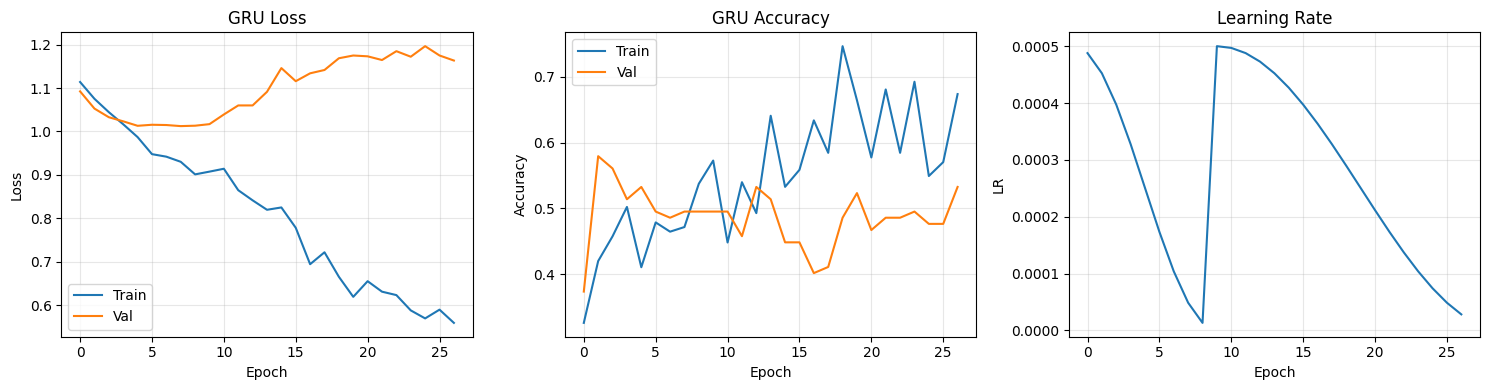

In [10]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_title('GRU Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Val')
axes[1].set_title('GRU Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning rate
axes[2].plot(history['learning_rate'])
axes[2].set_title('Learning Rate')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('LR')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.MODEL_DIR / 'gru_training_history.png', dpi=150)
plt.show()

## 11. Final Evaluation

Loading best GRU model...
Loaded model from epoch 2
Val F1: 0.5669, Val Acc: 0.5794


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]




GRU Validation Set Evaluation

Metrics:
  Accuracy:       0.5794
  Precision:      0.5897
  Recall:         0.5794
  F1 (weighted):  0.5823
  F1 (macro):     0.5669

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.48      0.59      0.53        27
        COPD       0.70      0.62      0.66        48
      Asthma       0.52      0.50      0.51        32

    accuracy                           0.58       107
   macro avg       0.57      0.57      0.57       107
weighted avg       0.59      0.58      0.58       107



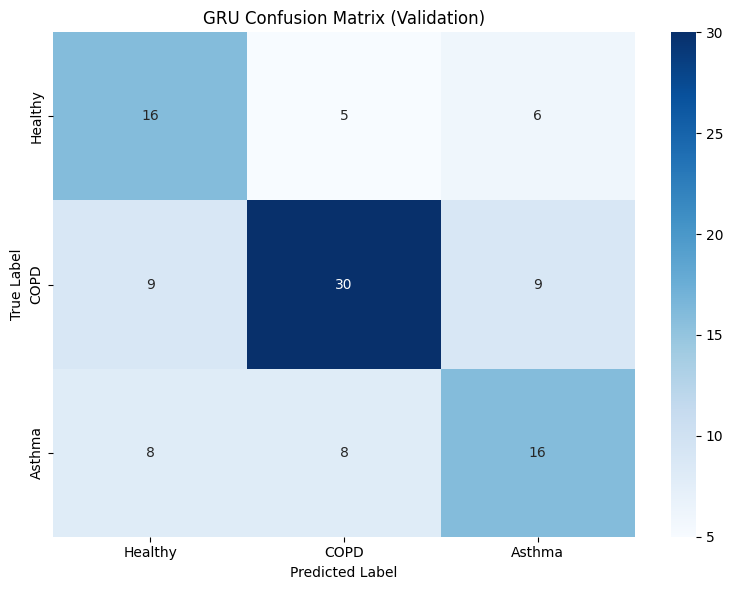

In [12]:
# Load best model
print("Loading best GRU model...")
checkpoint = torch.load(config.MODEL_DIR / 'best_gru_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1}")
print(f"Val F1: {checkpoint['val_f1']:.4f}, Val Acc: {checkpoint['val_acc']:.4f}")

# Evaluate on validation set
val_loss, val_acc, val_preds, val_labels, val_probs = validate_epoch(model, val_loader, criterion, device)
val_metrics = evaluate_model(val_labels, val_preds, title="GRU Validation Set Evaluation")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(val_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'COPD', 'Asthma'],
            yticklabels=['Healthy', 'COPD', 'Asthma'])
plt.title('GRU Confusion Matrix (Validation)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(config.MODEL_DIR / 'gru_confusion_matrix.png', dpi=150)
plt.show()

## 12. Generate Predictions for Test Set

In [13]:
# Generate predictions for test set
print("Generating predictions for test set...")
model.eval()
test_preds = []
test_probs = []
test_candidate_ids = []

with torch.no_grad():
    for audio, lengths, candidate_ids in tqdm(test_loader, desc="Predicting"):
        audio = audio.to(device)
        
        outputs = model(audio, lengths)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        test_preds.extend(preds.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())
        test_candidate_ids.extend(candidate_ids)

# Create predictions dictionary
predictions_dict = dict(zip(test_candidate_ids, test_preds))

# Handle missing candidates (use majority class = 2 as default)
all_test_candidates = test_df['candidateID'].tolist()
missing_candidates = [cid for cid in all_test_candidates if cid not in predictions_dict]

print(f"\nPredictions generated: {len(predictions_dict)}")
print(f"Missing candidates: {len(missing_candidates)}")

# Fill missing with majority class
for cid in missing_candidates:
    predictions_dict[cid] = 2  # Asthma as default

# Create submission
submission_df = pd.DataFrame({
    'candidateID': all_test_candidates,
    'disease': [predictions_dict[cid] for cid in all_test_candidates]
})

# Save submission
submission_path = config.BASE_PATH / 'submission_gru.csv'
submission_df.to_csv(submission_path, index=False)
print(f"\nSubmission saved to: {submission_path}")

# Show prediction distribution
print(f"\nTest Prediction Distribution:")
pred_counts = submission_df['disease'].value_counts().sort_index()
for cls, count in pred_counts.items():
    class_name = ['Healthy', 'COPD', 'Asthma'][int(cls)]
    print(f"  Class {cls} ({class_name}): {count} ({count/len(submission_df)*100:.1f}%)")

print(f"\n✓ GRU model training and prediction complete!")

Generating predictions for test set...


Predicting:  64%|██████▎   | 14/22 [00:02<00:01,  5.26it/s]

Error loading /mnt/ml_storage/Final_Project/SOURCE2/dataclean_vowel_1/c7288373c8b33/vowel.wav: [Errno 2] No such file or directory: '/mnt/ml_storage/Final_Project/SOURCE2/dataclean_vowel_1/c7288373c8b33/vowel.wav'


Predicting:  86%|████████▋ | 19/22 [00:03<00:00,  5.65it/s]

Error loading /mnt/ml_storage/Final_Project/SOURCE2/dataclean_vowel_1/ea49e069ef645/vowel.wav: [Errno 2] No such file or directory: '/mnt/ml_storage/Final_Project/SOURCE2/dataclean_vowel_1/ea49e069ef645/vowel.wav'


Predicting: 100%|██████████| 22/22 [00:03<00:00,  5.53it/s]


Predictions generated: 338
Missing candidates: 0

Submission saved to: /mnt/ml_storage/Final_Project/SOURCE2/submission_gru.csv

Test Prediction Distribution:
  Class 0 (Healthy): 114 (33.7%)
  Class 1 (COPD): 74 (21.9%)
  Class 2 (Asthma): 150 (44.4%)

✓ GRU model training and prediction complete!
